In [2]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
from PIL import Image
from IPython.display import display
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torch.nn.functional as F
import seaborn as sns
from torchvision import datasets, transforms, models
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
import torchvision.models as models
import PIL

In [3]:
data_path = '/kaggle/input/pets-facial-expression-dataset/Master Folder'

In [12]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(degrees=15, translate=(0.1, 0.1)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
train_data = datasets.ImageFolder(os.path.join(data_path, 'train'), transform = train_transform)
validation_data = datasets.ImageFolder(os.path.join(data_path, 'valid'), transform = train_transform)
test_data = datasets.ImageFolder(os.path.join(data_path, 'test'), transform = test_transform)
train_loader = DataLoader(train_data,
                          batch_size= 32, shuffle= True, pin_memory= False)
val_loader = DataLoader(validation_data,
                          batch_size= 32, shuffle= True, pin_memory= False)
test_loader = DataLoader(test_data,
                         batch_size= 32, shuffle= False, pin_memory= False)
classes = ['Angry','Sad','happy','Other']
class_names = train_data.classes
print(class_names)
print(f'Number of train images: {len(train_data)}')
print(f'Number of valid images: {len(validation_data)}')
print(f'Number of test images: {len(test_data)}')
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Available processor {}".format(device))

['Angry', 'Other', 'Sad', 'happy']
Number of train images: 1000
Number of valid images: 36
Number of test images: 38
Available processor cuda


In [13]:
class myVGG16(nn.Module):
    def __init__(self, num_classes=4):
        super(myVGG16, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(512 * 7 * 7, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, num_classes),
        )
    
    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

model = myVGG16(num_classes=4).to(device)
def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # Initialize biases to zero

model.apply(initialize_weights_xavier)

myVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

In [14]:
print(model)

myVGG16(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilati

Class weights: tensor([1., 1., 1., 1.], device='cuda:0')
Epoch [1/5], Step [32/32], Loss: 51.4856
Epoch [1/5] Training Completed. Loss: 223.2748, Accuracy: 22.40%
Epoch [1/5] Validation Completed. Loss: 45.1058, Accuracy: 16.67%
Epoch [2/5], Step [32/32], Loss: 39.5050
Epoch [2/5] Training Completed. Loss: 43.7391, Accuracy: 23.30%
Epoch [2/5] Validation Completed. Loss: 17.2013, Accuracy: 19.44%
Epoch [3/5], Step [32/32], Loss: 15.0643
Epoch [3/5] Training Completed. Loss: 17.3131, Accuracy: 26.60%
Epoch [3/5] Validation Completed. Loss: 10.1224, Accuracy: 16.67%
Epoch [4/5], Step [32/32], Loss: 5.1872
Epoch [4/5] Training Completed. Loss: 11.3987, Accuracy: 27.50%
Epoch [4/5] Validation Completed. Loss: 4.0567, Accuracy: 22.22%
Epoch [5/5], Step [32/32], Loss: 3.5350
Epoch [5/5] Training Completed. Loss: 7.4733, Accuracy: 23.80%
Epoch [5/5] Validation Completed. Loss: 3.1831, Accuracy: 16.67%
Training complete.


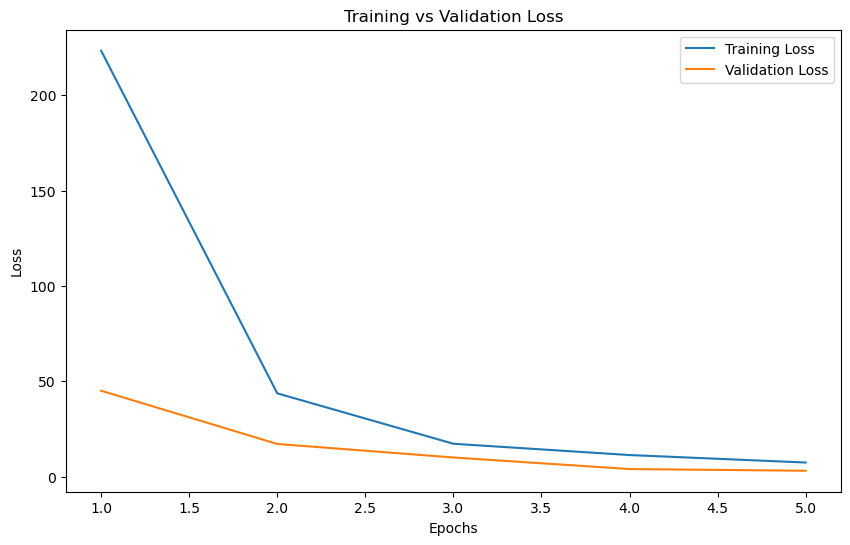

In [17]:
model =  model.to(device)
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import torch

# Step 1: Access the targets directly from the dataset used in train_loader
all_labels = []
for _, labels in train_loader:  # Collect all labels from the DataLoader
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# Step 2: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Step 3: Define criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Print class weights for verification
print(f"Class weights: {class_weights}")

batch_size = 32
learning_rate = 1e-4
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  
    total_correct = 0
    total_samples = 0
    running_loss = 0.0
    learning_rate = learning_rate / 10

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

        if (i+1) % 32 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_accuracy = (total_correct / total_samples) * 100
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] Training Completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    model.eval()  
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = (val_total_correct / val_total_samples) * 100
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Completed. Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Training complete.')


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Accuracy: 28.95%
Mean Precision: 0.15
Mean Recall: 0.30
Mean F1-score: 0.20

Confusion Matrix:
[[0 2 7 1]
 [0 3 3 0]
 [0 3 8 0]
 [0 2 9 0]]


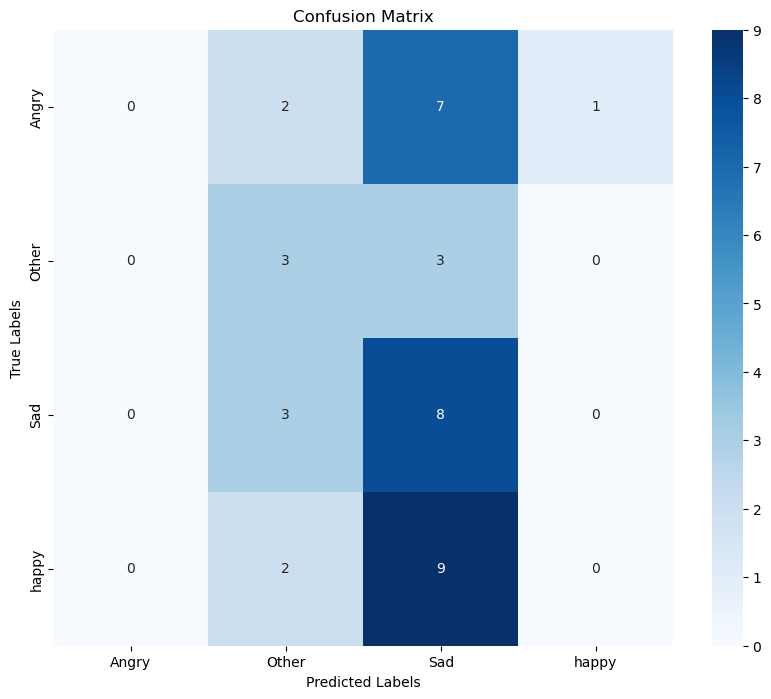

In [18]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs= model(images)  
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = np.mean(all_predictions == all_labels) * 100

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_report = classification_report(
    all_labels, 
    all_predictions, 
    target_names=class_names,  
    output_dict=True
)


mean_precision = np.mean([v['precision'] for k, v in class_report.items() if k != 'accuracy'])
mean_recall = np.mean([v['recall'] for k, v in class_report.items() if k != 'accuracy'])
mean_f1 = np.mean([v['f1-score'] for k, v in class_report.items() if k != 'accuracy'])


print(f'Accuracy: {accuracy:.2f}%')
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-score: {mean_f1:.2f}')
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [36]:
model = models.vgg16(pretrained=True)
model.classifier[6] = nn.Linear(in_features=4096, out_features=4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [37]:
print(model)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [38]:
model =  model.to(device)
all_labels = []
for _, labels in train_loader:  # Collect all labels from the DataLoader
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# Step 2: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Step 3: Define criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Print class weights for verification
print(f"Class weights: {class_weights}")

batch_size = 32
learning_rate = 1e-5
num_epochs = 7
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

        if (i+1) % 32 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_accuracy = (total_correct / total_samples) * 100
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] Training Completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    model.eval()  
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = (val_total_correct / val_total_samples) * 100
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Completed. Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Training complete.')

Class weights: tensor([1., 1., 1., 1.], device='cuda:0')
Epoch [1/7], Step [32/32], Loss: 1.3985
Epoch [1/7] Training Completed. Loss: 1.3907, Accuracy: 31.60%
Epoch [1/7] Validation Completed. Loss: 1.3297, Accuracy: 44.44%
Epoch [2/7], Step [32/32], Loss: 1.2302
Epoch [2/7] Training Completed. Loss: 1.2727, Accuracy: 39.80%
Epoch [2/7] Validation Completed. Loss: 1.2902, Accuracy: 38.89%
Epoch [3/7], Step [32/32], Loss: 1.1984
Epoch [3/7] Training Completed. Loss: 1.2040, Accuracy: 46.30%
Epoch [3/7] Validation Completed. Loss: 1.3585, Accuracy: 44.44%
Epoch [4/7], Step [32/32], Loss: 1.0992
Epoch [4/7] Training Completed. Loss: 1.1475, Accuracy: 47.80%
Epoch [4/7] Validation Completed. Loss: 1.1404, Accuracy: 47.22%
Epoch [5/7], Step [32/32], Loss: 0.5501
Epoch [5/7] Training Completed. Loss: 1.0713, Accuracy: 53.20%
Epoch [5/7] Validation Completed. Loss: 1.1406, Accuracy: 38.89%
Epoch [6/7], Step [32/32], Loss: 0.9884
Epoch [6/7] Training Completed. Loss: 1.0269, Accuracy: 56.00%


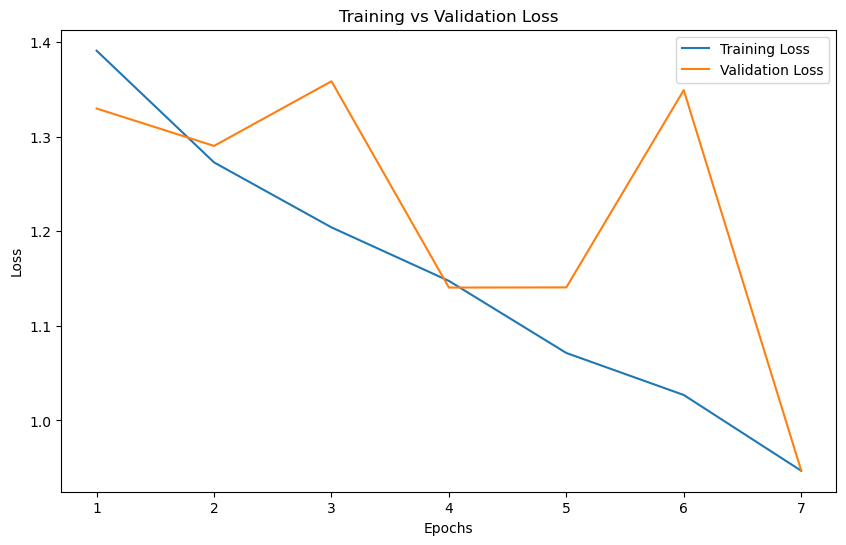

In [39]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Accuracy: 44.74%
Mean Precision: 0.45
Mean Recall: 0.44
Mean F1-score: 0.44

Confusion Matrix:
[[7 1 1 1]
 [1 2 3 0]
 [2 0 5 4]
 [3 1 4 3]]


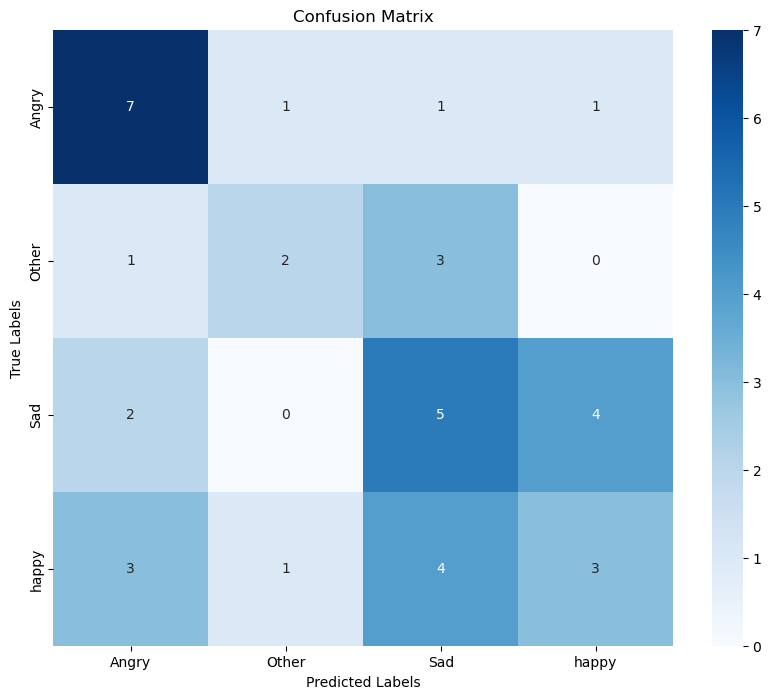

In [40]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs= model(images)  
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = np.mean(all_predictions == all_labels) * 100

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_report = classification_report(
    all_labels, 
    all_predictions, 
    target_names=class_names,  
    output_dict=True
)


mean_precision = np.mean([v['precision'] for k, v in class_report.items() if k != 'accuracy'])
mean_recall = np.mean([v['recall'] for k, v in class_report.items() if k != 'accuracy'])
mean_f1 = np.mean([v['f1-score'] for k, v in class_report.items() if k != 'accuracy'])


print(f'Accuracy: {accuracy:.2f}%')
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-score: {mean_f1:.2f}')
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [41]:
import torch
import torch.nn as nn

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.batchnorm2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample

    def forward(self, x):
        identity = x
        if self.downsample is not None:
            identity = self.downsample(x)

        out = self.conv1(x)
        out = self.batchnorm1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.batchnorm2(out)

        out = out + identity
        out = self.relu(out)

        return out

class myResNet34(nn.Module):
    def __init__(self, block, layers, num_classes=4):
        super(myResNet34, self).__init__()
        self.in_channels = 64
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.batchnorm1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        self.layer1 = self.construct_layer(block, 64, layers[0])
        self.layer2 = self.construct_layer(block, 128, layers[1], stride=2)
        self.layer3 = self.construct_layer(block, 256, layers[2], stride=2)
        self.layer4 = self.construct_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def construct_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion),
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.batchnorm1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

model = myResNet34(BasicBlock, [3, 4, 6, 3], 4).to(device)


In [42]:
print(model)
def initialize_weights_xavier(m):
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        torch.nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # Initialize biases to zero

model.apply(initialize_weights_xavier)

myResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

myResNet34(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (batchnorm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

Class weights: tensor([1., 1., 1., 1.], device='cuda:0')
Epoch [1/5], Step [32/32], Loss: 1.6359
Epoch [1/5] Training Completed. Loss: 1.5396, Accuracy: 28.30%
Epoch [1/5] Validation Completed. Loss: 1.6069, Accuracy: 33.33%
Epoch [2/5], Step [32/32], Loss: 1.7328
Epoch [2/5] Training Completed. Loss: 1.5126, Accuracy: 27.20%
Epoch [2/5] Validation Completed. Loss: 2.0159, Accuracy: 25.00%
Epoch [3/5], Step [32/32], Loss: 1.2526
Epoch [3/5] Training Completed. Loss: 1.4586, Accuracy: 27.60%
Epoch [3/5] Validation Completed. Loss: 1.6747, Accuracy: 38.89%
Epoch [4/5], Step [32/32], Loss: 1.5077
Epoch [4/5] Training Completed. Loss: 1.4404, Accuracy: 29.40%
Epoch [4/5] Validation Completed. Loss: 1.5546, Accuracy: 19.44%
Epoch [5/5], Step [32/32], Loss: 1.6977
Epoch [5/5] Training Completed. Loss: 1.4147, Accuracy: 28.70%
Epoch [5/5] Validation Completed. Loss: 1.5210, Accuracy: 25.00%
Training complete.


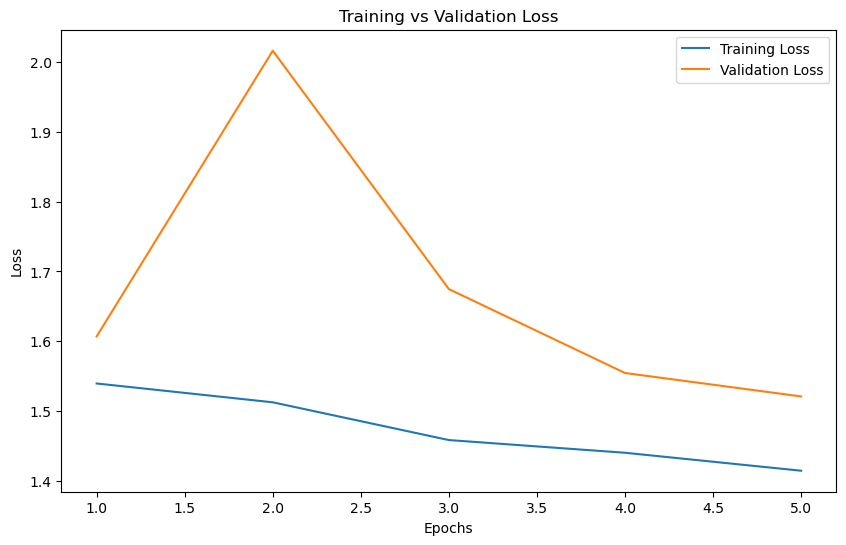

In [48]:
model =  model.to(device)
all_labels = []
for _, labels in train_loader:  # Collect all labels from the DataLoader
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# Step 2: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Step 3: Define criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Print class weights for verification
print(f"Class weights: {class_weights}")

batch_size = 32
learning_rate = 1e-3
num_epochs = 5
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  
    total_correct = 0
    total_samples = 0
    running_loss = 0.0
    learning_rate = learning_rate / 100
    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

        if (i+1) % 32 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

    epoch_accuracy = (total_correct / total_samples) * 100
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] Training Completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    model.eval()  
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = (val_total_correct / val_total_samples) * 100
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Completed. Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Training complete.')


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Accuracy: 26.32%
Mean Precision: 0.47
Mean Recall: 0.25
Mean F1-score: 0.26

Confusion Matrix:
[[3 6 1 0]
 [4 1 1 0]
 [4 2 5 0]
 [3 5 2 1]]


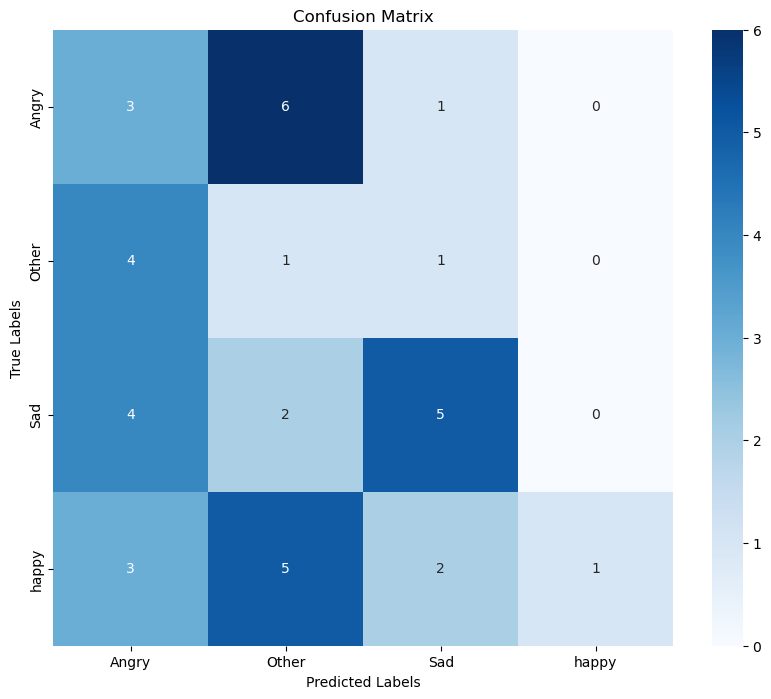

In [49]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs= model(images)  
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = np.mean(all_predictions == all_labels) * 100

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_report = classification_report(
    all_labels, 
    all_predictions, 
    target_names=class_names,  
    output_dict=True
)


mean_precision = np.mean([v['precision'] for k, v in class_report.items() if k != 'accuracy'])
mean_recall = np.mean([v['recall'] for k, v in class_report.items() if k != 'accuracy'])
mean_f1 = np.mean([v['f1-score'] for k, v in class_report.items() if k != 'accuracy'])


print(f'Accuracy: {accuracy:.2f}%')
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-score: {mean_f1:.2f}')
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

In [50]:
model = models.resnet34(pretrained=True)
model.fc = nn.Linear(in_features=512, out_features=4)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 281MB/s]


In [51]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Class weights: tensor([1., 1., 1., 1.], device='cuda:0')
Epoch [1/6], Step [32/32], Loss: 0.1484
Epoch [1/6] Training Completed. Loss: 0.1101, Accuracy: 96.40%
Epoch [1/6] Validation Completed. Loss: 2.7734, Accuracy: 44.44%
Epoch [2/6], Step [32/32], Loss: 0.0642
Epoch [2/6] Training Completed. Loss: 0.1417, Accuracy: 95.60%
Epoch [2/6] Validation Completed. Loss: 1.5702, Accuracy: 52.78%
Epoch [3/6], Step [32/32], Loss: 0.0178
Epoch [3/6] Training Completed. Loss: 0.0938, Accuracy: 96.70%
Epoch [3/6] Validation Completed. Loss: 2.4772, Accuracy: 50.00%
Epoch [4/6], Step [32/32], Loss: 0.0474
Epoch [4/6] Training Completed. Loss: 0.0543, Accuracy: 98.10%
Epoch [4/6] Validation Completed. Loss: 3.1154, Accuracy: 38.89%
Epoch [5/6], Step [32/32], Loss: 0.0321
Epoch [5/6] Training Completed. Loss: 0.0690, Accuracy: 98.20%
Epoch [5/6] Validation Completed. Loss: 2.7549, Accuracy: 33.33%
Epoch [6/6], Step [32/32], Loss: 0.4906
Epoch [6/6] Training Completed. Loss: 0.0753, Accuracy: 97.90%


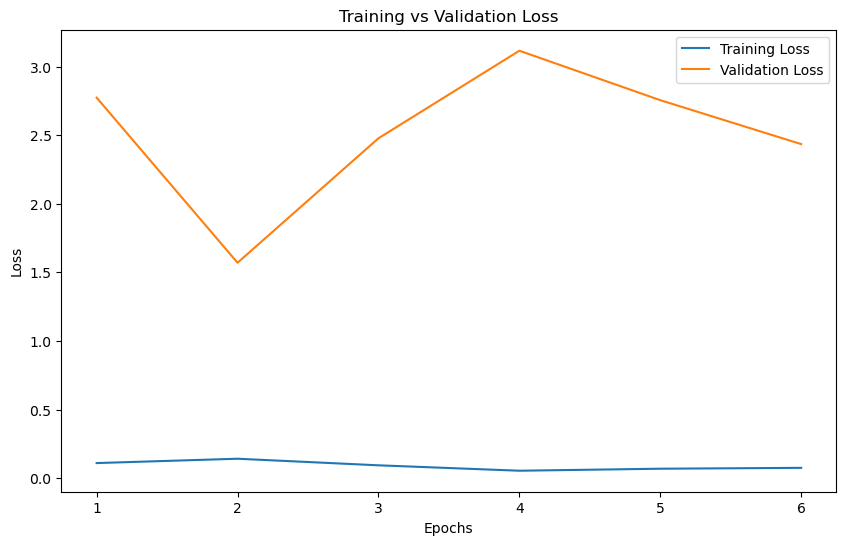

In [58]:
model =  model.to(device)
all_labels = []
for _, labels in train_loader:  # Collect all labels from the DataLoader
    all_labels.extend(labels.numpy())
all_labels = np.array(all_labels)

# Step 2: Compute class weights
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(all_labels),
    y=all_labels
)
class_weights = torch.tensor(class_weights, dtype=torch.float).to(device)

# Step 3: Define criterion with class weights
criterion = nn.CrossEntropyLoss(weight=class_weights)

# Print class weights for verification
print(f"Class weights: {class_weights}")

batch_size = 32
learning_rate = 1e-4
num_epochs = 6
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for epoch in range(num_epochs):
    model.train()  
    total_correct = 0
    total_samples = 0
    running_loss = 0.0

    for i, (images, labels) in enumerate(train_loader):
        images = images.to(device)
        labels = labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)
        running_loss += loss.item()

        if (i+1) % 32 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{len(train_loader)}], Loss: {loss.item():.4f}')
    learning_rate = learning_rate / 10
    epoch_accuracy = (total_correct / total_samples) * 100
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    print(f'Epoch [{epoch+1}/{num_epochs}] Training Completed. Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%')

    model.eval()  
    val_running_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():  
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            _, predicted = torch.max(outputs, 1)
            val_total_correct += (predicted == labels).sum().item()
            val_total_samples += labels.size(0)
            val_running_loss += loss.item()

    val_loss = val_running_loss / len(val_loader)
    val_losses.append(val_loss)

    val_accuracy = (val_total_correct / val_total_samples) * 100
    print(f'Epoch [{epoch+1}/{num_epochs}] Validation Completed. Loss: {val_loss:.4f}, Accuracy: {val_accuracy:.2f}%')

print('Training complete.')


plt.figure(figsize=(10, 6))
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.show()

Accuracy: 52.63%
Mean Precision: 0.55
Mean Recall: 0.50
Mean F1-score: 0.50

Confusion Matrix:
[[3 1 2 4]
 [1 2 1 2]
 [1 0 7 3]
 [1 0 2 8]]


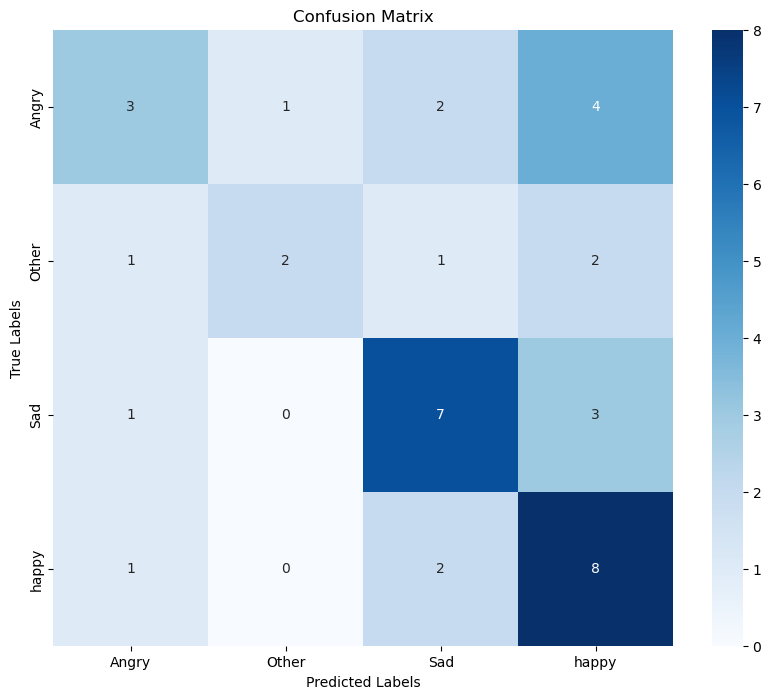

In [59]:
model.eval()

all_labels = []
all_predictions = []

with torch.no_grad(): 
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs= model(images)  
        _, predicted = torch.max(outputs, 1)

        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

accuracy = np.mean(all_predictions == all_labels) * 100

conf_matrix = confusion_matrix(all_labels, all_predictions)

class_report = classification_report(
    all_labels, 
    all_predictions, 
    target_names=class_names,  
    output_dict=True
)


mean_precision = np.mean([v['precision'] for k, v in class_report.items() if k != 'accuracy'])
mean_recall = np.mean([v['recall'] for k, v in class_report.items() if k != 'accuracy'])
mean_f1 = np.mean([v['f1-score'] for k, v in class_report.items() if k != 'accuracy'])


print(f'Accuracy: {accuracy:.2f}%')
print(f'Mean Precision: {mean_precision:.2f}')
print(f'Mean Recall: {mean_recall:.2f}')
print(f'Mean F1-score: {mean_f1:.2f}')
print("\nConfusion Matrix:")
print(conf_matrix)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()